<a href="https://colab.research.google.com/github/Nicordaro/Project_MLDL/blob/master/%20Copy_of_main_iCaRL_marco.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

*Cloning files needed*

In [0]:
import os
# Clone github repository with data
# if os.path.isdir('./Project_MLDL'):
!rm -rf Project_MLDL
if not os.path.isdir('./CIFAR100_tError'):
  !git clone https://github.com/Nicordaro/Project_MLDL


Cloning into 'Project_MLDL'...
remote: Enumerating objects: 6, done.
remote: Counting objects: 100% (6/6), done.
remote: Compressing objects: 100% (6/6), done.
remote: Total 226 (delta 2), reused 0 (delta 0), pack-reused 220
Receiving objects: 100% (226/226), 876.72 KiB | 2.31 MiB/s, done.
Resolving deltas: 100% (109/109), done.


**Imports**

---

In [0]:
import logging
import matplotlib.pyplot as plt
import numpy as np
import random
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim


from PIL import Image
from Project_MLDL.CIFAR100_tError import CIFAR100_tError
from Project_MLDL.model_finetuning import ResNet18
from torch.utils.data import Subset, DataLoader
from torch.backends import cudnn
from torchvision import transforms
from torchvision.models import resnet18
from torchvision.models import resnet34
from tqdm import tqdm

**Arguments**

---





In [0]:
DEVICE = 'cuda' # 'cuda' or 'cpu'

# Init at 10 because first train is on 10 classes
NUM_CLASSES = 10

# Used for the pseudorandom shuffle of the split
SEED = 12

BATCH_SIZE = 128     # Higher batch sizes allows for larger learning rates. An empirical heuristic suggests that, when changing
                     # the batch size, learning rate should change by the same factor to have comparable results

LR = 2         # The initial Learning Rate
MOMENTUM = 0.9       # Hyperparameter for SGD, keep this at 0.9 when using SGD
WEIGHT_DECAY = 1e-5  # Regularization, you can keep this at the default

NUM_EPOCHS = 70     # Total number of training epochs (iterations over dataset)
MILESTONES = [48, 62]  # How many epochs before decreasing learning rate (if using a step-down policy)
GAMMA = 0.2          # Multiplicative factor for learning rate step-down

LOG_FREQUENCY = 50

**Transformations definition**

---



In [0]:
# Define transforms for training phase
train_transform = transforms.Compose([transforms.RandomHorizontalFlip(), # Randomly flip the image with probability of 0.5
                                      transforms.Pad(4), # Add padding
                                      transforms.RandomCrop(32),# Crops a random squares of the image
                                      transforms.ToTensor(), # Turn PIL Image to torch.Tensor
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))  # https://gist.github.com/weiaicunzai/e623931921efefd4c331622c344d8151
])
# Define transforms for the evaluation phase
eval_transform = transforms.Compose([
                                      transforms.ToTensor(),
                                      transforms.Normalize((0.485, 0.456, 0.406), (0.229, 0.224, 0.225))                                 
])

*New label function*

In [0]:
DATA_DIR = './CIFAR100'

lbls = [i for i in range(0,100)]  #Array of classes integer-encoded (?)
random.seed(SEED)
random.shuffle(lbls)

def make_data_labels(lbls):       #After shuffle, take first 10 classes, and remove the first 10 from the list passed as argument
    new_labels=[]
    for el in lbls[:10]:
        new_labels.append(el)
    lbls = lbls[10:]

    return lbls, new_labels

In [0]:
for j in range(1,2):
  print(1)

1


**Network Definition**

---

In [0]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class iCaRL(nn.Module):
  def __init__(self):
    super(iCaRL, self).__init__()

    self.feature_extractor = ResNet18()
    self.feature_extractor.linear = nn.Linear(512, 2048)
    self.relu = nn.ReLU()
    self.fc = nn.Linear(2048, 100)

    self.cls_loss = nn.BCEWithLogitsLoss()
    self.dist_loss = nn.BCELoss()

    self.optimizer = optim.SGD(self.parameters(), lr=2, weight_decay=1e-5, momentum=0.9)

    self.exemplar_sets=[]
    self.exemplars_means=[]

  def forward(self, x):
    x = self.feature_extractor(x)
    x = nn.functional.norm(x)
    x = self.relu(x)
    x = self.fc(x)
    return x

  def classify(self, x):
    
    # x is a single image
    x  = x.unsqueeze(dim=0)

    exemplar_means = []

    # Compute exemplar means
    for Py in self.exemplar_sets:
      features=[]
      for p in Py:
        feature = self.feature_extractor(p)
        features.append(feature)
      features = torch.stack(features)
      mu_y = features.mean(0) # compute the mean for class y
      mu_y.data = mu_y.data / mu_y.data.norm() # Normalize
      exemplar_means.append(mu_y) # array of means, one for each class

    self.exemplar_means = exemplar_means #update array of exemplar means
  
    means = torch.cat(exemplar_means,dim=0) # (n_classes, feature_size)
    feature_x = self.feature_extractor(x) # (1, feature_size)

    # normalize 
    for i in range(feature_x.size(0)):
      feature_x.data[i] = feature_x.data[i] / feature_x.data[i].norm()

    feature_x = torch.cat([feature_x]*means.size()[0],dim=0)

    # find the nearest prototype
    label = torch.argmin((feature_x - means).pow(2).sum(1),dim=0)

    return label.item()

  def reduce_exemplar_sets(self,m,Py):
    return Py[:m]
  
  def construct_exemplar_set(self,X,m):
    
    # X dataset containing all elements of class y

    loader = DataLoader(X,128,True,drop_last=False) # create dataloader

    features = []
    for images,labels in loader:
      feature = self.feature_extractor(images) #(batchsize, 2048)
      features.append(feature)

    features_stacked = torch.cat(features)# (size,2048)
    mean = features_stacked.mean(0) #current class mean (1,2048)
    mean = torch.stack([mean]*features_stacked.size()[0]) # (size,2048)
     

    P = [] # exemplar set
    for k in range(1,m+1):
      print(f"step {k}")
      s = torch.zeros(1,2048)
      for j in range(1,k):
        s = s + self.feature_extractor(P[j-1])
      s = torch.cat([s]*features_stacked.size()[0])
      index = torch.argmin((mean-(1/k)*(features_stacked+s)).pow(2).sum(1),dim=0)
      pk = X[index.item()][0].unsqueeze(dim=0)
      P.append(pk)
     
    self.exemplar_sets.append(P)

    return P

  # def update_representation(self,X):

  #   # X set of training images X1,X2.. of class 1,2.. class+label

  #   # form combined training set

  #   dataset = []
  #   for y,Py in enumerate(self.exemplar_sets):
  #     for image in Py:
  #       dataset.append(image,y) # l'indice corrisponde alla classe? da verificare
  #   for i,Xi in enumerate(X):
  #     for image in Xi:
  #       dataset.append(image,i)

  #   #now dataset is a list of (tensor,label)

  #   # store network outputs with pre updated parameters
  #   n_classes = len(X)+ len(self.exemplar_sets)
  #   loader = Dataloader(dataset,batch_size = 128,shuffle=True,num_workers = 4)
  #   torch.zeros(len(dataset), n_classes)
  #   for i,(image,label) in enumerate(loader):
  #     g = nn.sigmoid(self.forward(image))
  #     q[i] = g.data()

  #   # run network training with loss function
  #   current_step = 0
  #   for epoch in range(NUM_EPOCHS):
  #     print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
  #     for images, labels in loader: 
  #           # Bring data over the device of choice
  #           images = images.to(DEVICE)
  #           labels = labels.to(DEVICE)

  #           net.train() # Sets module in training mode

  #           # PyTorch, by default, accumulates gradients after each backward pass
  #           # We need to manually set the gradients to zero before starting a new iteration
  #           optimizer.zero_grad() # Zero-ing the gradients

  #           # Forward pass to the network
  #           outputs = self.forward(images)
      
  #           # One hot encoding labels for binary cross-entropy loss
  #           labels_onehot = nn.functional.one_hot(labels,100)
  #           labels_onehot = labels_onehot.type_as(outputs)

  #           loss = self.cls_loss(outputs, labels_onehot)

  #           # Distillation loss
  #           g = nn.sigmoid(outputs)
  #           qi = q[i]
  #           distillation = sum(self.dist_loss(g[:,y], qi[:,y]) for y in range(len(self.exemplar_sets)))
  #           loss += distillation 
      
  #           if current_step % LOG_FREQUENCY == 0:
  #               print('Step {}, Loss {}'.format(current_step, loss.item()))

  #       # Compute gradients for each layer and update weights
  #           loss.backward()  # backward pass: computes gradients
  #           optimizer.step() # update weights based on accumulated gradients
  #           current_step += 1

  #     scheduler.step()

In [0]:
train_dataset1 = CIFAR100_tError(DATA_DIR, train=True, transform=train_transform, download=True)
train_dataset2 = CIFAR100_tError(DATA_DIR, train=True, transform=train_transform, download=True)
train_dataset3 = CIFAR100_tError(DATA_DIR, train=True, transform=train_transform, download=True)
test_dataset = CIFAR100_tError(DATA_DIR, train=False, transform=train_transform, download=True)
train_dataset1.increment([0],[0])
train_dataset2.increment([79],[1])
train_dataset3.increment([20],[2])
test_dataset.increment([0],[0])
train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)  

Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified
Files already downloaded and verified


In [0]:
net = iCaRL()
net.construct_exemplar_set(train_dataset1,2)
net.construct_exemplar_set(train_dataset2,2)


step 1
step 2
step 1
step 2


[tensor([[[[-2.1179, -2.1179,  2.2489,  ...,  2.1119,  2.0605,  1.9749],
           [-2.1179, -2.1179,  2.2489,  ...,  2.0777,  2.0263,  1.9407],
           [-2.1179, -2.1179,  2.2489,  ...,  2.0434,  1.9920,  1.9235],
           ...,
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179],
           [-2.1179, -2.1179, -2.1179,  ..., -2.1179, -2.1179, -2.1179]],
 
          [[-2.0357, -2.0357,  2.4286,  ...,  2.4286,  2.4286,  2.4286],
           [-2.0357, -2.0357,  2.4286,  ...,  2.4286,  2.4111,  2.4286],
           [-2.0357, -2.0357,  2.4286,  ...,  2.4286,  2.4111,  2.4111],
           ...,
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357],
           [-2.0357, -2.0357, -2.0357,  ..., -2.0357, -2.0357, -2.0357]],
 
          [[-1.8044, -1.8044,  2.6400,  ...,  2.6400,  2.6400,  2.6400],
           [-

In [0]:
l = net.exemplar_sets[1]

In [0]:
l = net.classify(test_dataset[0][0])
l

0

In [0]:
len(net.exemplar_sets)

1

In [0]:
for images,labels in train_dataloader:
  print(images.size())
  break

torch.Size([128, 3, 32, 32])


In [0]:
mean = torch.tensor([[1,1,1]]) #media
features = torch.rand(2,3)
mean = torch.cat([mean]*2)
value = (mean-features).pow(2).sum(1)
value

tensor([0.9715, 0.1746])

In [0]:
index = torch.argmin(value,dim=0)
index.item()

1

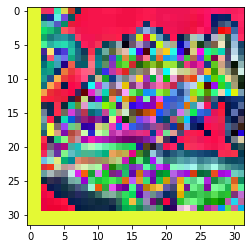

In [0]:
import matplotlib.pyplot as plt
import numpy
trans = transforms.ToPILImage(mode='RGB')
img = lista[8]
plt.imshow(trans(img.squeeze()))
#plt.imshow(lista[0].numpy(), cmap='gray')

In [0]:
t1 = torch.tensor([[1,2,3]])
t1 = torch.cat([t1]*5)
t1

tensor([[1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3],
        [1, 2, 3]])

**Train, Validation** *not so fair* **and Test**

---



In [0]:
import numpy as np
import copy
BATCH_TO_TEST = 10
test_accuracies = []

best_eval_accuracy = 0


# Define test dataset outside in order to increment it, instead of initializing it every cycle iteration
test_dataset = CIFAR100_tError(DATA_DIR, train=False, transform=eval_transform, download=True)
for i in range(0,BATCH_TO_TEST): #one iteration for 10 classes
    print(f'Starting training with batch {i+1}')
    lbls, new_labels = make_data_labels(lbls)
  
    # Define Train dataset
    train_dataset = CIFAR100_tError(DATA_DIR, train=True, transform=train_transform, download=True)       
    eval_dataset = CIFAR100_tError(DATA_DIR, train=False, transform=eval_transform, download=True)
    # Increment dataset with new labels mapped with list comprehension
    train_dataset.increment(new_labels,[j for j in range(0+i*10,10+i*10)])
    eval_dataset.increment(new_labels,[j for j in range(0+i*10,10+i*10)])
    test_dataset.increment(new_labels,[j for j in range(0+i*10,10+i*10)])

    # Define dataloader
    train_dataloader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, drop_last=True)
    eval_dataloader = DataLoader(eval_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)
    test_dataloader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=4)

    #prepare training
    # Loss function
    criterion = nn.BCEWithLogitsLoss() # for classification, we use Cross Entropy

    # Parameters to optimize:
    parameters_to_optimize = net.parameters()

    # Optimizer
    optimizer = optim.SGD(parameters_to_optimize, lr=LR, momentum=MOMENTUM, weight_decay=WEIGHT_DECAY)
    # Scheduler
    scheduler = optim.lr_scheduler.MultiStepLR(optimizer, milestones=MILESTONES, gamma=GAMMA, last_epoch=-1)

    # training 
    # By default, everything is loaded to cpu
    net = net.to(DEVICE) # this will bring the network to GPU if DEVICE is cuda

    cudnn.benchmark # Calling this optimizes runtime

    current_step = 0

    # Start iterating over the epochs
    for epoch in range(NUM_EPOCHS):
      print('Starting epoch {}/{}, LR = {}'.format(epoch+1, NUM_EPOCHS, scheduler.get_last_lr()))
    
        # Iterate over the dataset
      for images, labels in train_dataloader:
          # Bring data over the device of choice
          images = images.to(DEVICE)
          labels = labels.to(DEVICE)

          net.train() # Sets module in training mode

          # PyTorch, by default, accumulates gradients after each backward pass
          # We need to manually set the gradients to zero before starting a new iteration
          optimizer.zero_grad() # Zero-ing the gradients

          # Forward pass to the network
          outputs = net(images)
    
          # One hot encoding labels for binary cross-entropy loss
          labels_onehot = nn.functional.one_hot(labels,100)
          labels_onehot = labels_onehot.type_as(outputs)

          loss = criterion(outputs, labels_onehot)
    
          if current_step % LOG_FREQUENCY == 0:
              print('Step {}, Loss {}'.format(current_step, loss.item()))

      # Compute gradients for each layer and update weights
          loss.backward()  # backward pass: computes gradients
          optimizer.step() # update weights based on accumulated gradients
          current_step += 1
    	  # Validation    
      eval_accuracy = testNet(float(len(eval_dataset)), eval_dataloader, net)
      if eval_accuracy > best_eval_accuracy:
        best_eval_accuracy = eval_accuracy
        best_model = copy.deepcopy(net)
        print('Validation Accuracy: {}'.format(eval_accuracy))


        # Step the scheduler
      scheduler.step()

    #test phase
    test_accuracy = testNet(float(len(test_dataset)), test_dataloader, best_model)
    test_accuracies.append(test_accuracy)
    print('Test Accuracy: {}'.format(test_accuracy))

Extracting ./CIFAR100/cifar-100-python.tar.gz to ./CIFAR100
Starting training with batch 1
Files already downloaded and verified
Files already downloaded and verified

Starting epoch 1/70, LR = [2]
Step 0, Loss 0.7239236235618591
Validation Accuracy: 0.435
Starting epoch 2/70, LR = [2]
Step 50, Loss 0.023589059710502625
Validation Accuracy: 0.501
Starting epoch 3/70, LR = [2]
Step 100, Loss 0.0217558853328228
Starting epoch 4/70, LR = [2]
Step 150, Loss 0.01812673732638359
Validation Accuracy: 0.572
Starting epoch 5/70, LR = [2]
Validation Accuracy: 0.619
Starting epoch 6/70, LR = [2]
Step 200, Loss 0.01858242228627205
Starting epoch 7/70, LR = [2]
Step 250, Loss 0.018882043659687042
Starting epoch 8/70, LR = [2]
Step 300, Loss 0.014633851125836372
Starting epoch 9/70, LR = [2]
Step 350, Loss 0.01673528179526329
Validation Accuracy: 0.657
Starting epoch 10/70, LR = [2]
Starting epoch 11/70, LR = [2]
Step 400, Loss 0.01442048791795969
Starting epoch 12/70, LR = [2]
Step 450, Loss 0.0171

**Define plot function**

---



In [0]:
def accuracy_plot(accuracies):
  ### FOR MEAN STD PLOT https://stackoverflow.com/questions/22481854/plot-mean-and-standard-deviation
  from scipy import interpolate

  tck,u     = interpolate.splprep( [[i*10 for i in range(1,len(accuracies)+1)],accuracies] ,s = 0 )
  xnew,ynew = interpolate.splev( np.linspace( 0, 1, 100 ), tck,der = 0)

  fig, ax = plt.subplots(figsize=(15,14), facecolor='white')

  plt.rc('font', size=20)
  plt.plot( [i*10 for i in range(1,len(accuracies)+1)],accuracies,'.' , xnew ,ynew, label = "accuracy", c='orange' )
  ax.set_ylabel("Accuracy")
  ax.set_xlabel("Classes")
  ax.minorticks_on()
  plt.title("Accuracies obtained with finetuning of a ResNet network")
  plt.yticks(np.arange(0, 1.1, .1))
  plt.xticks(np.arange(0, 110, 10))
  plt.grid(axis='y',which='major', linestyle='-', linewidth='0.5', color='black') 
  plt.grid(axis='y',which='minor', linestyle=':', linewidth='0.5', color='grey')
  for in_i, in_j in zip([i*10 for i in range(1,len(accuracies)+1)], accuracies):  # Plot also the value of the point close to it
          ax.annotate(str(round(in_j, 3)), xy=(in_i, in_j))

  plt.savefig('test.png', format='png', dpi=300)
  plt.show()

*Print & Plot*

[0.84, 0.4595, 0.30666666666666664, 0.23, 0.184, 0.15383333333333332, 0.13185714285714287, 0.115375, 0.10644444444444444, 0.0958]


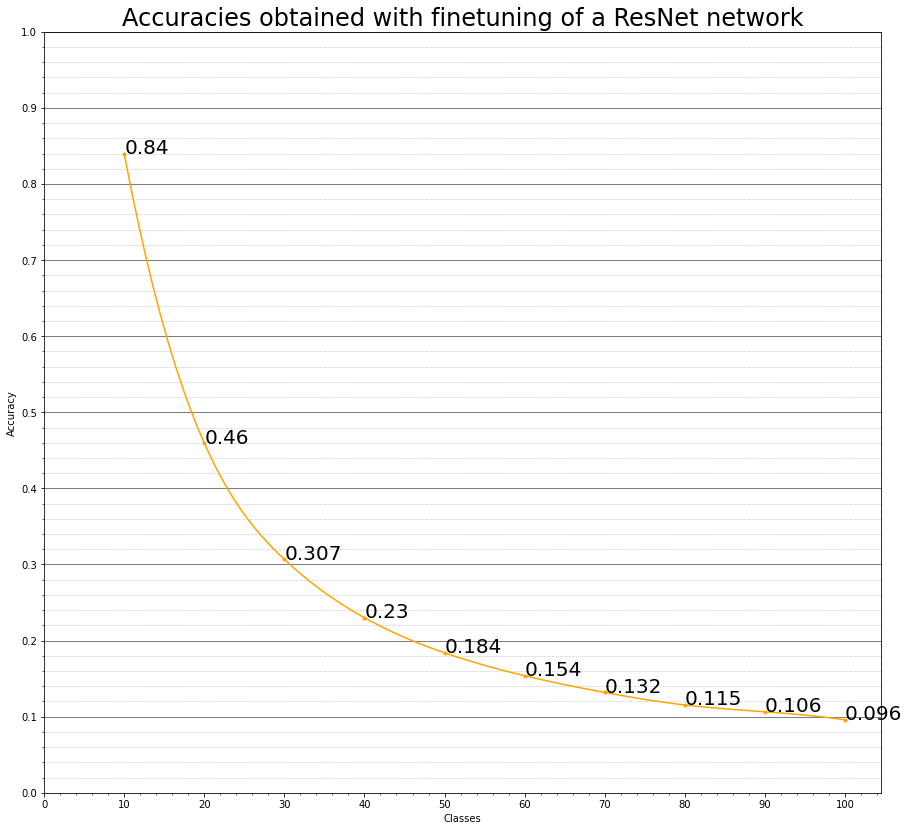

In [0]:
print(test_accuracies)

accuracy_plot(test_accuracies)
#obtained [0.844, 0.4525, 0.2976666666666667, 0.224, 0.1808, 0.1535, 0.125, 0.113625, 0.10577777777777778, 0.0929]